In [1]:
import torch
import torch.nn as nn

from datasets import load_dataset
import functools
from collections import defaultdict

from functools import partial
import numpy as np
from tqdm import tqdm

/home/jwjeong/anaconda3/envs/quant/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
)
from auto_gptq import AutoGPTQForCausalLM

In [3]:
def build_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
    kwargs = {"torch_dtype": torch.float16, "device_map": "sequential"}
    model = AutoModelForCausalLM.from_pretrained(model_name, **kwargs)
    return model, tokenizer


In [4]:
model_name = 'facebook/opt-6.7b'
device = "cuda:1"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
testenc = tokenizer("\n\n".join(dataset["text"]), return_tensors="pt")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/home/jwjeong/anaconda3/envs/quant/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


In [5]:
from utils import opt_eval
opt_eval(model, testenc, device)

10.860100746154785

In [5]:
from utils import evaluate_opt
evaluate_opt(model, testenc)

evaluating...: 100%|██████████| 40/40 [01:15<00:00,  1.89s/it]


tensor(10.6736, device='cuda:1')

In [6]:
from quant import quant_unpack, dequant_unpack
bits = 4
gs = 128
scale, zero, qs = quant_unpack(bits, gs, model)
q_x = dequant_unpack(scale, zero, qs, gs)
for key in q_x.keys():
    if key.split('.')[-1] != 'lm_head':
        weight = key+'.weight'
        model.state_dict()[weight][:] = q_x[key]

In [7]:
from transformers.pytorch_utils import Conv1D

In [8]:
def get_activation_for_ffn(model, dataset, tokenizer, num_samples=512, seq_len=512):
    model.eval()
    device = next(model.parameters()).device # next는 객체의 __next__ 호출, 다음 iter를 부름?
    act_ffn_min = {}
    act_ffn_max = {}

    def stat_tensor(name, tensor):
        hidden_dim = tensor.shape[-1]
        tensor = tensor.view(-1, hidden_dim).detach() # detach method는 gradient 전파를 멈춤
        if name in act_ffn_min:
            act_ffn_min[name] = tensor.min() if act_ffn_min[name] > tensor.min() else act_ffn_min[name]
            act_ffn_max[name] = tensor.max() if act_ffn_max[name] < tensor.max() else act_ffn_max[name]
        else:
            act_ffn_min[name] = tensor.min()
            act_ffn_max[name] = tensor.max()
    
    def stat_input_hook(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]
        stat_tensor(name, x)

    hooks = []
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear) | isinstance(m, Conv1D):
            hooks.append(
                m.register_forward_hook(
                    functools.partial(stat_input_hook, name=name))
            )
    
    dataset = dataset.shuffle(seed=42)
    dataset_list = []
    for ii in range(len(dataset)):
        if dataset[ii]['text'] != '':
            dataset_list.append(dataset[ii])

    for i in tqdm(range(num_samples)):
        input_ids = tokenizer(dataset_list[i]["text"], return_tensors="pt",
                              max_length=seq_len, truncation=True).input_ids.to(device)
        model(input_ids)

    for h in hooks:
        h.remove()

    return act_ffn_min, act_ffn_max


In [8]:
actmin, actmax = get_activation_for_ffn(model, dataset, tokenizer)

100%|██████████| 512/512 [01:24<00:00,  6.06it/s]


In [9]:
actmax

{'model.decoder.layers.0.self_attn.q_proj': tensor(9.4007, device='cuda:1'),
 'model.decoder.layers.0.self_attn.k_proj': tensor(9.4007, device='cuda:1'),
 'model.decoder.layers.0.self_attn.v_proj': tensor(9.4007, device='cuda:1'),
 'model.decoder.layers.0.self_attn.out_proj': tensor(3.3230, device='cuda:1'),
 'model.decoder.layers.0.fc1': tensor(60.2647, device='cuda:1'),
 'model.decoder.layers.0.fc2': tensor(9.9572, device='cuda:1'),
 'model.decoder.layers.1.self_attn.q_proj': tensor(61.8691, device='cuda:1'),
 'model.decoder.layers.1.self_attn.k_proj': tensor(61.8691, device='cuda:1'),
 'model.decoder.layers.1.self_attn.v_proj': tensor(61.8691, device='cuda:1'),
 'model.decoder.layers.1.self_attn.out_proj': tensor(1.3059, device='cuda:1'),
 'model.decoder.layers.1.fc1': tensor(62.8497, device='cuda:1'),
 'model.decoder.layers.1.fc2': tensor(8.9117, device='cuda:1'),
 'model.decoder.layers.2.self_attn.q_proj': tensor(62.8723, device='cuda:1'),
 'model.decoder.layers.2.self_attn.k_proj

In [10]:
actmin

{'model.decoder.layers.0.self_attn.q_proj': tensor(-7.5230, device='cuda:1'),
 'model.decoder.layers.0.self_attn.k_proj': tensor(-7.5230, device='cuda:1'),
 'model.decoder.layers.0.self_attn.v_proj': tensor(-7.5230, device='cuda:1'),
 'model.decoder.layers.0.self_attn.out_proj': tensor(-5.3593, device='cuda:1'),
 'model.decoder.layers.0.fc1': tensor(-41.0152, device='cuda:1'),
 'model.decoder.layers.0.fc2': tensor(0., device='cuda:1'),
 'model.decoder.layers.1.self_attn.q_proj': tensor(-29.4048, device='cuda:1'),
 'model.decoder.layers.1.self_attn.k_proj': tensor(-29.4048, device='cuda:1'),
 'model.decoder.layers.1.self_attn.v_proj': tensor(-29.4048, device='cuda:1'),
 'model.decoder.layers.1.self_attn.out_proj': tensor(-1.5218, device='cuda:1'),
 'model.decoder.layers.1.fc1': tensor(-28.2201, device='cuda:1'),
 'model.decoder.layers.1.fc2': tensor(0., device='cuda:1'),
 'model.decoder.layers.2.self_attn.q_proj': tensor(-25.1512, device='cuda:1'),
 'model.decoder.layers.2.self_attn.k_p

In [9]:
evaluate_opt(model, testenc)

evaluating...: 100%|██████████| 40/40 [01:15<00:00,  1.89s/it]


tensor(11.1499, device='cuda:1')

In [8]:
from utils import opt_eval
opt_eval(model, testenc, device)

11.321776390075684

In [7]:
import scipy.sparse as sp

def lin_weight_identifier(name):
    linear_list = [
    #'k_proj',
    #'v_proj',
    #'q_proj',
    #'out_proj',
    'fc1',
    'fc2',
    ]
    isWeight = name.split('.')[-1] == 'weight'
    isLinear = name.split('.')[-2] in linear_list
    return (isWeight and isLinear)

def conv_bin2int(bin, bitwidth):
    if bitwidth == 32:
        dtype = torch.int32
    elif bitwidth == 16:
        dtype = torch.int16
    else:
        dtype = torch.int8
    
    bin = bin.view(-1, bitwidth).T.type(dtype)
    sign = bin[0]
    sum = torch.zeros(bin.size(-1), dtype=dtype)
    for i in range(1, len(bin)):
        bin[i] = sign ^ bin[i]
        sum += bin[i] * 2**((bitwidth-1)-i)
    
    mult_sign = torch.where(sign == 0, torch.tensor(1, dtype=dtype), torch.tensor(-1, dtype=dtype))

    sum = (mult_sign*sum) - sign.view(dtype)
    return sum
    

def error_gen(param, rate, seed):
    orig_size = param.size()
    bitwidth = param.data.element_size()*8
    
    bin_error = torch.tensor(sp.random(np.prod(orig_size), bitwidth, density=rate, dtype=bool, random_state=np.random.default_rng(seed)).toarray())
    error_matrix = conv_bin2int(bin_error, bitwidth)
    del bin_error
    return error_matrix.view(orig_size)

def error_injection(param, rate, seed, device="cuda"):
    err_mat = error_gen(param, rate, seed).to(device)
    int_form = err_mat.dtype
    param.data[:] = (param.data.view(int_form) ^ err_mat).view(param.dtype)
    del err_mat

In [8]:
for name, param in model.named_parameters():
    if lin_weight_identifier(name) is True:
        error_injection(param, 1e-4, 44, param.device)

In [9]:
act_scales_after_error = get_activation_for_ffn(model, tokenizer)

100%|██████████| 512/512 [00:10<00:00, 46.78it/s]


In [19]:
seq_act = dict()
seq_act_err = dict()
seq_len = 50494
for i in range(seq_len):
    for key in act_scales.keys():
        if i in seq_act:
            seq_act[i] = torch.concat([seq_act[i], act_scales[key][i]], dim=0)
            seq_act_err[i] = torch.concat([seq_act_err[i], act_scales_after_error[key][i]], dim=0)
        else:
            seq_act[i] = act_scales[key][i]
            seq_act_err[i] = act_scales_after_error[key][i]

KeyboardInterrupt: 

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np
# 예시 데이터 (768x61 형태) 생성을 위한 코드

def plot_3D(data):
    # 새로운 meshgrid 생성
    x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0])) # x와 y의 범위를 data의 형태에 맞게 조정

    # Create a 3D plot with the updated meshgrid
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the surface with the correct shapes
    ax.plot_surface(x, y, data.numpy(), cmap='viridis')

    # Setting labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Show the plot
    plt.show()


model.model.decoder.layers.0.self_attn.q_proj


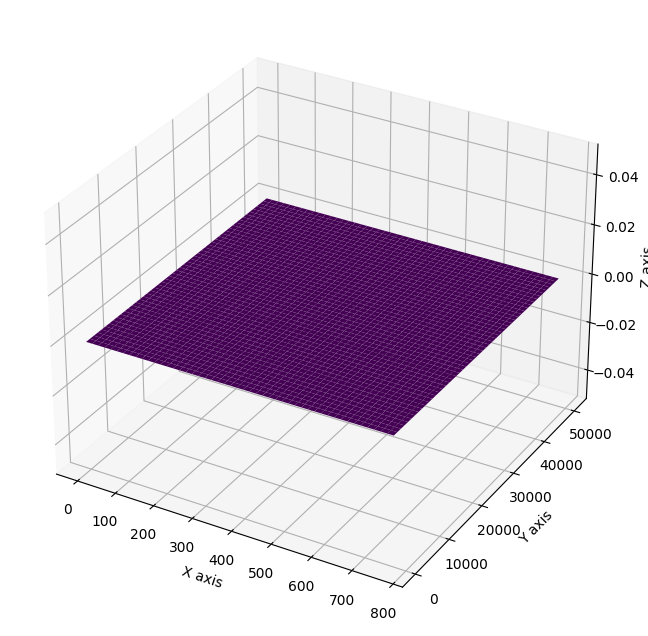

model.model.decoder.layers.0.self_attn.k_proj


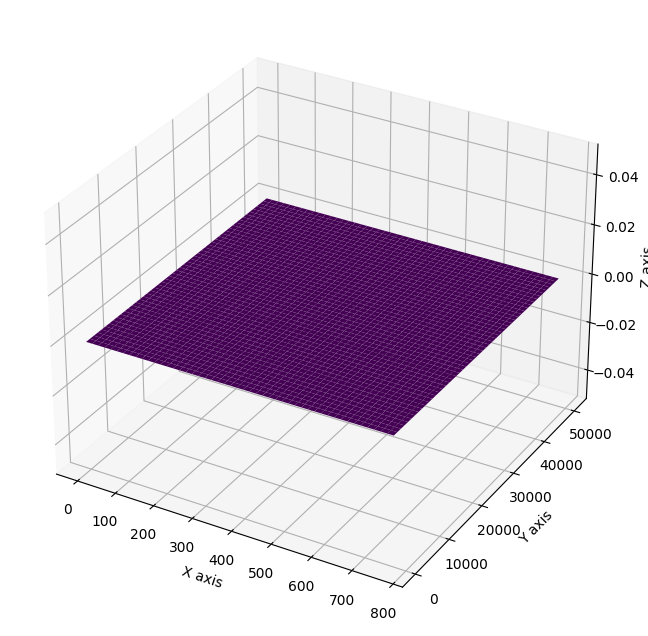

model.model.decoder.layers.0.self_attn.v_proj


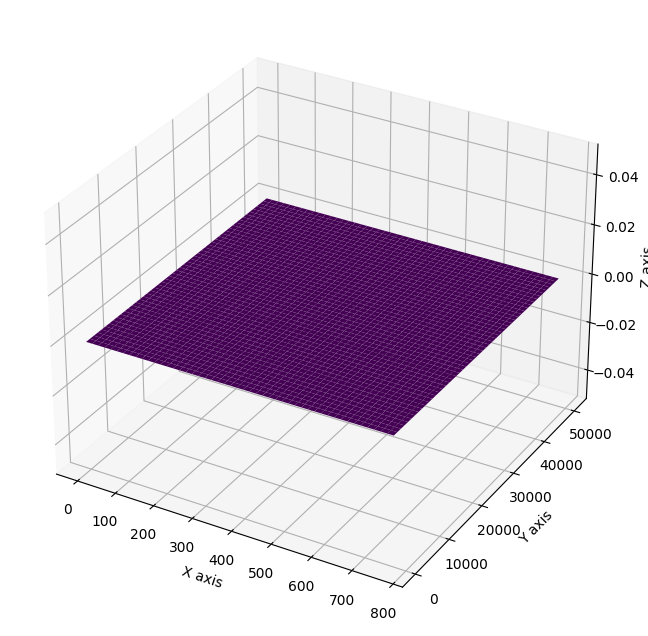

model.model.decoder.layers.0.self_attn.out_proj


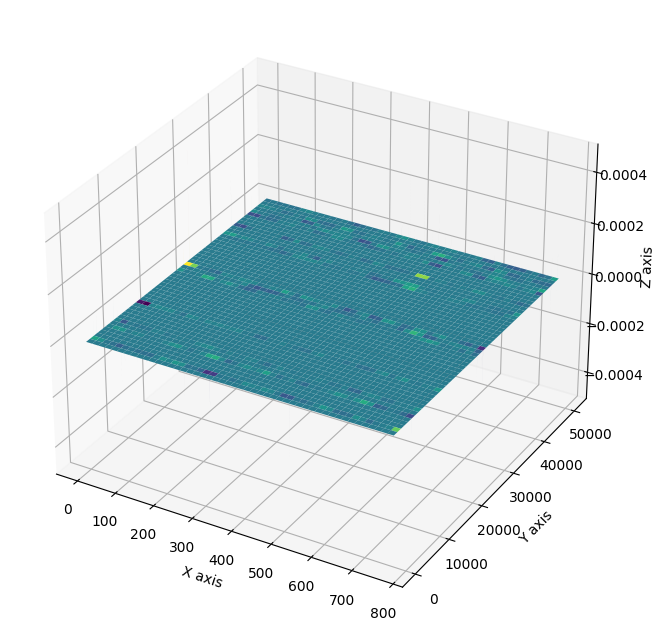

model.model.decoder.layers.0.fc1


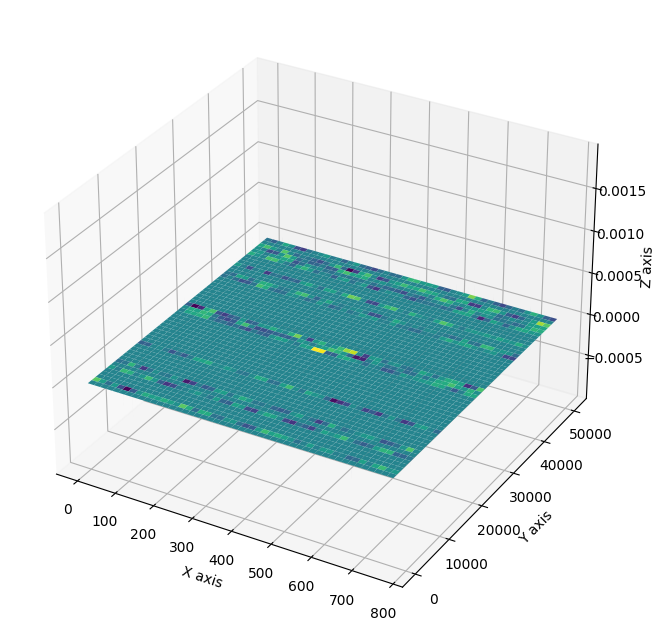

model.model.decoder.layers.0.fc2


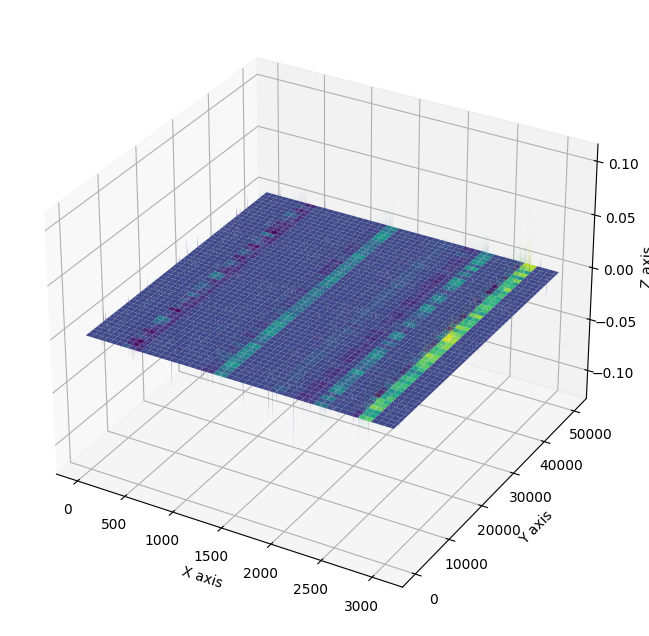

model.model.decoder.layers.1.self_attn.q_proj


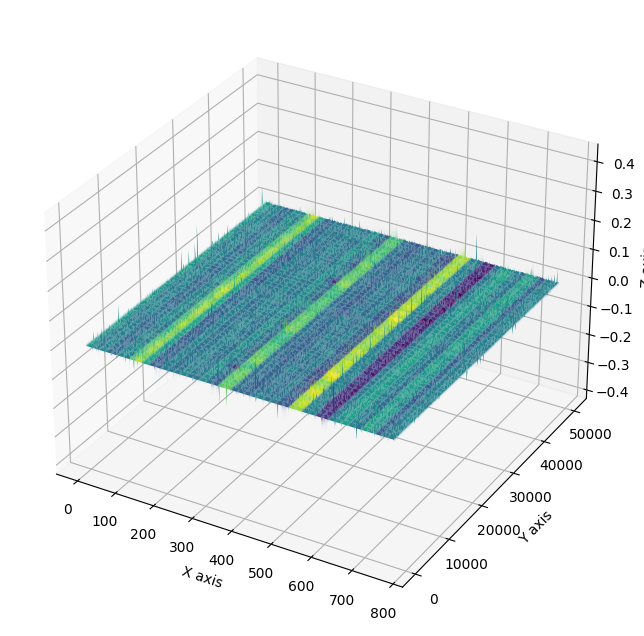

model.model.decoder.layers.1.self_attn.k_proj


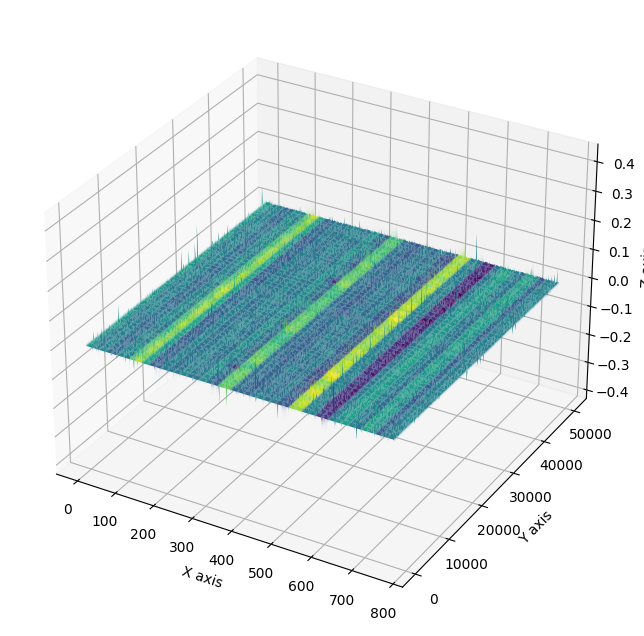

model.model.decoder.layers.1.self_attn.v_proj


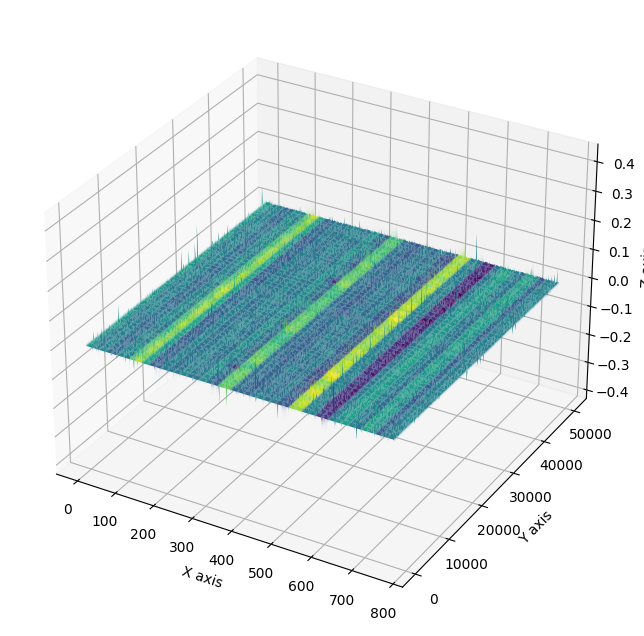

model.model.decoder.layers.1.self_attn.out_proj


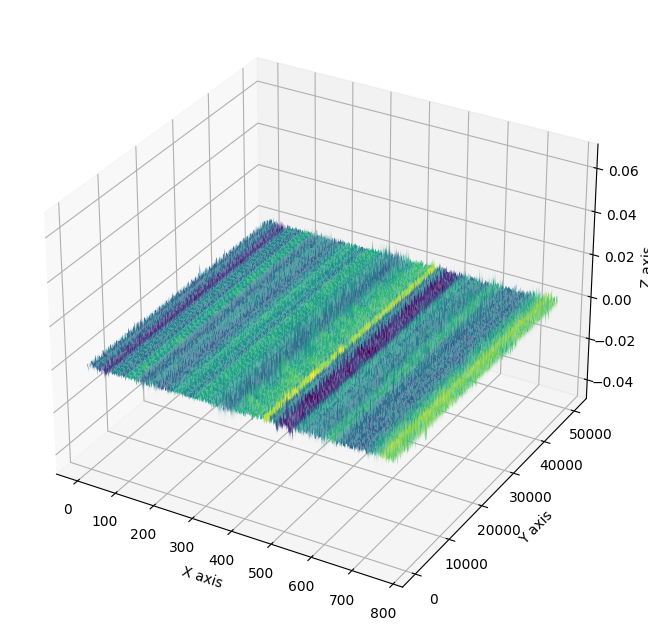

model.model.decoder.layers.1.fc1


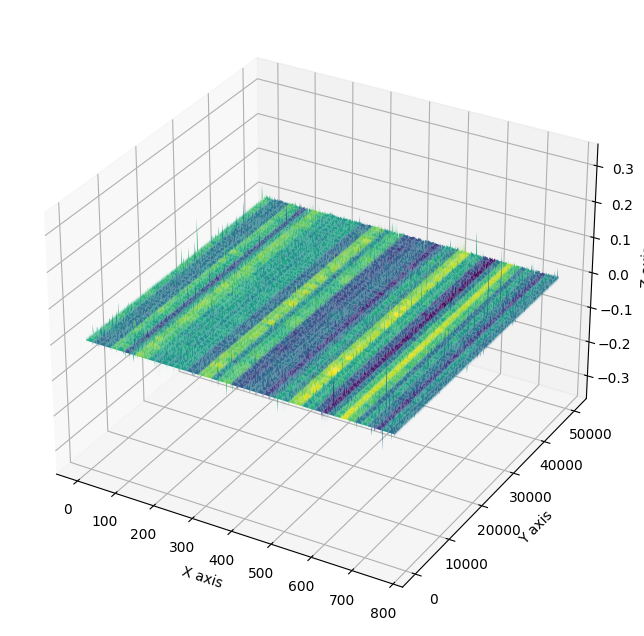

model.model.decoder.layers.1.fc2


KeyboardInterrupt: 

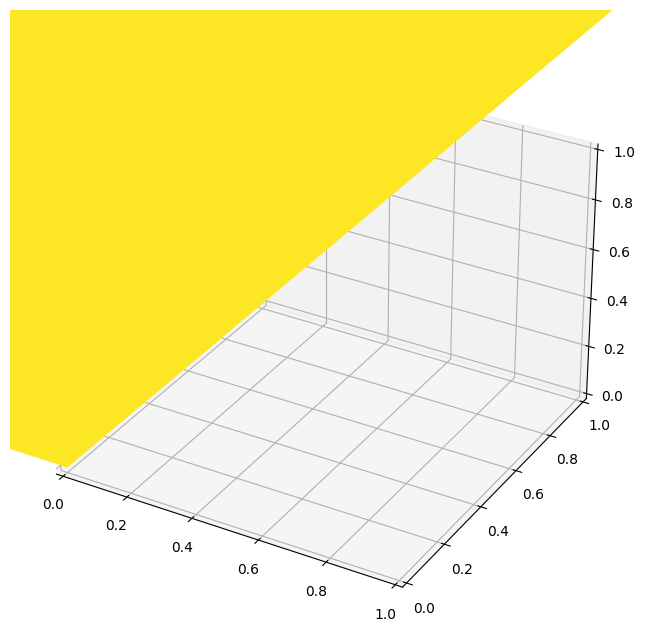

In [11]:
def cos_sim(A, B):
    return torch.cosine_similarity(A, B)

def euclidean_dist(A, B):
    return torch._euclidean_dist(A, B).squeeze()

In [12]:
similarity = {}
dist = {}

for key in act_scales.keys():
    similarity[key] = list()
    dist[key] = list()
    for i in range(len(act_scales[key])):
        orig = act_scales[key][i].view(1, -1)
        errord = act_scales_after_error[key][i].view(1, -1)
        similarity[key].append(cos_sim(orig, errord))
        dist[key].append(euclidean_dist(orig, errord))

In [15]:
act_scales

KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt

In [ ]:
act_dim = []
for key in act_scales.keys():
    if act_scales[key].size() not in act_dim:
        act_dim.append(act_scales[key].size())

print(act_dim)

short_dim = []
long_dim = []
for key in act_scales.keys():
    if act_scales[key].size() == act_dim[0]:
        short_dim.append(act_scales[key])
    else:
        long_dim.append(act_scales[key])

[torch.Size([5120]), torch.Size([20480])]


In [ ]:
act_scales_short = torch.concat(short_dim)
act_scales_long = torch.concat(long_dim)

act_scales_short = act_scales_short.view(-1, act_dim[0][0])
act_scales_long = act_scales_long.view(-1, act_dim[1][0])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np
# 예시 데이터 (768x61 형태) 생성을 위한 코드

def plot_3D(data):
    # 새로운 meshgrid 생성
    x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0])) # x와 y의 범위를 data의 형태에 맞게 조정

    # Create a 3D plot with the updated meshgrid
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the surface with the correct shapes
    ax.plot_surface(x, y, data.numpy(), cmap='viridis')

    # Setting labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Show the plot
    plt.show()


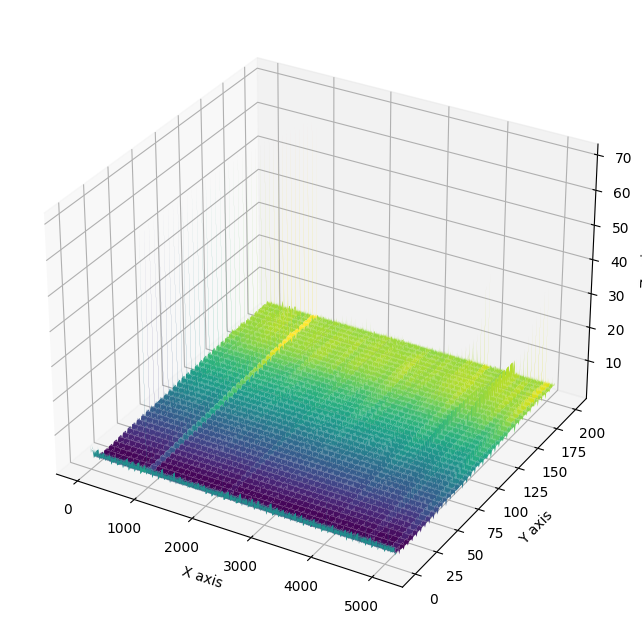

In [ ]:
plot_3D(act_scales_short)

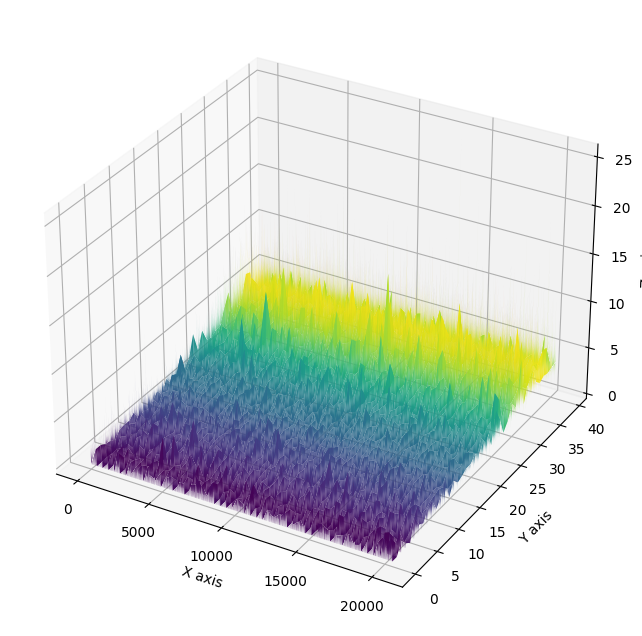

In [ ]:
plot_3D(act_scales_long)

In [64]:
linear = [
    'k_proj',
    'q_proj',
    'v_proj',
    'out_proj',
    'fc1',
    'fc2',
]
weight_short = []
weight_long = []
for name, param in model.named_parameters():
    if name.split('.')[-2] in linear:
        if name.split('.')[-1] == 'weight':
            if param.size() == torch.Size([768, 768]):
                weight_short.append(param)

weight_short = torch.concat(weight_short)

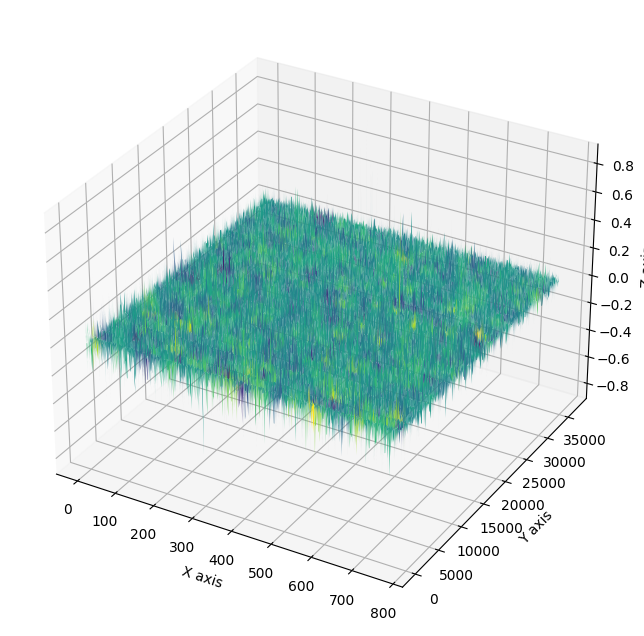

In [69]:
plot_3D(weight_short.detach())